In [ ]:
%load_ext autoreload
%autoreload 2

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import concurrent.futures
import timeit
from typing import Callable, List, Optional, Tuple
from functools import partial
import copy
from itertools import groupby
import sys, os
from scipy.optimize import minimize
from scipy.spatial.distance import (
    cosine
)

from data_loader import load_grid_search_data


# Fig. 4 ABCD, recon error v.s. sampling fraction

In [ ]:
def vis_recon_error(ax, nq_range, inst_range, sf_range, errors, plot_type, title: str, start: int=1):
    errors = errors.reshape(len(nq_range), len(inst_range), len(sf_range))

    
    print("shape before transpose: ", errors.shape)
    # print(errors)
    errors = errors.transpose(0, 2, 1)
    print("shape after transpose: ", errors.shape)

    for i in range(len(nq_range)):
        if plot_type == 'box':
            ax.boxplot(errors[0])

        elif plot_type == 'quantiles':
            y = errors[i, start:] # shape = (len(sf_range), len(inst_range))
            y = np.nanquantile(y, q=(0.25, 0.5, 0.75), axis=1) 
            # print(y)
            x = np.array(sf_range[start:])
            # x = np.range(len(sf_range[start:]))
            # print(x)
            label = f"{nq_range[i]} qubits"
            fmt = "" 
            ax.errorbar( 
                x,
                # y[1][x],
                y[1], 
                # yerr=(y[1][x] - y[0][x], y[2][x] - y[1][x]), 
                yerr=(y[1] - y[0], y[2] - y[1]), 
                label=label, 
                alpha=0.75, 
                fmt=fmt, 
                capsize=3, 
                capthick=1, 
            ) 
            # plt.fill_between(x, y1=y[0][x], y2=y[2][x], alpha=0.25)
            ax.fill_between(x, y1=y[0], y2=y[2], alpha=0.25)
        elif plot_type == 'line':
            ax.plot(sf_range[start:],
                errors[i,start:,:].mean(axis=-1),
                label=f"{nq_range[i]} qubits")
        else:
            raise NotImplementedError()

    ax.set_title(title, y=-0.32)
    # ax.legend()
    # plt.show()
    return


def vis_maxcut(ax, p: int, noise: str, error_type: str):
    
    if p == 1 and noise == 'ideal':
        recon_error_data = np.load(
            "figs/grid_search_recon/qaoa/maxcut/sv-ideal-p=1/recon_error_ns=[16, 20, 24, 30]-seeds=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]-sfs=[0.01 0.03 0.05 0.07 0.09]-error=NRMSE.npz"
            # "figs/grid_search_recon/maxcut/sv-ideal-p=1/recon_error_ns=[16, 20, 24, 30]-seeds=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
            # "figs/grid_search_recon/maxcut/sv-ideal-p=1/recon_error_ns=[16, 20, 24, 30]-seeds=[0, 1, 2, 3, 4, 5, 6, 7]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
            , allow_pickle=True
        )
        nq_range = [16, 20, 24, 30]
        inst_range = list(range(16))
        title = f"(A) "
        title += f"{p=}, {noise}" # , {len(inst_range)} instances"
    elif p == 1 and noise == 'depolar-0.003-0.007':
        recon_error_data = np.load(
            "figs/grid_search_recon/qaoa/maxcut/sv-depolar-0.003-0.007-p=1/recon_error_ns=[12, 16, 20]-seeds=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]-sfs=[0.01 0.03 0.05 0.07 0.09]-error=NRMSE.npz"
            # "figs/grid_search_recon/maxcut/sv-depolar-0.003-0.007-p=1/recon_error_ns=[12, 16, 20]-seeds=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
            # "figs/grid_search_recon/maxcut/sv-depolar-0.003-0.007-p=1/recon_error_ns=[12, 16, 20]-seeds=[0, 1, 2, 3, 4, 5, 6, 7]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
            , allow_pickle=True
        )
        nq_range = [12, 16, 20]
        inst_range = list(range(16))
        title = "(B) "
        title += f"{p=}, noisy" # , {len(inst_range)} instances"
    elif p == 2 and noise == 'ideal':
        recon_error_data = np.load(
            "figs/grid_search_recon/qaoa/maxcut/sv-ideal-p=2/recon_error_ns=[16, 20, 24]-seeds=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]-sfs=[0.01 0.03 0.05 0.07 0.09]-error=NRMSE.npz"
            # "figs/grid_search_recon/maxcut/sv-ideal-p=2/recon_error_ns=[16, 20, 24]-seeds=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
            # "figs/grid_search_recon/maxcut/sv-ideal-p=2/recon_error_ns=[16, 20, 24]-seeds=[0, 1, 2, 3, 4, 5, 6, 7]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
            , allow_pickle=True)
        nq_range = [12, 16, 20]
        inst_range = list(range(16))
        title = "(C) "
        title += f"{p=}, {noise}" # , {len(inst_range)} instances"
    elif p == 2 and noise == 'depolar-0.003-0.007':
        recon_error_data = np.load(
            "figs/grid_search_recon/qaoa/maxcut/sv-depolar-0.003-0.007-p=2/recon_error_ns=[12, 16, 20]-seeds=[0, 1, 2, 3, 4, 5, 6, 7]-sfs=[0.01 0.03 0.05 0.07 0.09]-error=NRMSE.npz"
            # "figs/grid_search_recon/maxcut/sv-depolar-0.003-0.007-p=2/recon_error_ns=[12, 16]-seeds=[0, 1, 2, 3, 4, 5, 6, 7]-sfs=[0.01 0.03 0.05 0.07 0.09]-error=NRMSE.npz"
            , allow_pickle=True
        )
        title = "(D) "
        nq_range = [12, 16, 20]
        inst_range = list(range(8))
        title += f"{p=}, noisy" # , {len(inst_range)} instances"

    # if noise == 'depolar-0.001-0.005':
    #     # depolarizing 0.001, 0.005
    #     mse = [0.5294567889697064, 0.10504512962369626, 0.0313981299420259, 0.012503321574744162, 0.008140374429632507, 0.8424334405179074, 0.10568723568802518, 0.03212506658687189, 0.014080103905186459, 0.009296142398008756, 0.526865075200324, 0.12747919612932213, 0.06309042154958099, 0.049028926963782395, 0.017344741404916143, 0.5292877712080678, 0.12807155118871388, 0.06338557278944737, 0.04927365907019386, 0.01742941715973452, 1.9361662554992944, 0.11117192831199525, 0.05794935815783304, 0.042218665732938074, 0.031913622196141994, 1.9274262480485385, 0.11380618083255489, 0.06048147435362607, 0.042544439403038134, 0.032231339880888894]
    #     cos = [0.03345611343649668, 0.001882758932071349, 0.00018351884817768838, 3.2312424903535586e-05, 1.3707400878582021e-05, 0.1189645214978915, 0.00180777477491334, 0.0001907390154839428, 4.040555030127013e-05, 1.7545841520250072e-05, 0.023844061448096587, 0.002032726517411043, 0.0004999788199564481, 0.00030430659574010033, 3.7662019811590675e-05, 0.02382890847269281, 0.0020325601979672703, 0.0004999731174260003, 0.0003044908765591492, 3.767714656655041e-05, 0.3036874338519604, 0.0008274828744364582, 0.0002466740593143335, 0.0001358167458470616, 7.858596328635947e-05, 0.29930637856623044, 0.0008437189310439575, 0.0002633779178375928, 0.0001353103607633077, 7.849847216112593e-05]
        
    # elif noise == 'depolar-0.003-0.007':
    #     mse = [0.5039391145820539, 0.10187541579824788, 0.030521028927380053, 0.012100274958501474, 0.007879699198447391, 0.8164015928099697, 0.10280057365192978, 0.031246832290654097, 0.013655930917672875, 0.00904611410285615, 0.5111357466189159, 0.12415765730594497, 0.06143917804136556, 0.047700887403396286, 0.016817643074515512, 0.5106162502837763, 0.12448309263267172, 0.06159363454853711, 0.047782653207815724, 0.016818108440983092, 1.8821332493158773, 0.10812472566677976, 0.05626310971617496, 0.040952219495018434, 0.030904712822065413, 1.8743446567979802, 0.11086259352599241, 0.05872780804047352, 0.04143577374538176, 0.031403123343349756]
    #     cos = [0.03136409094172088, 0.0018815084299171891, 0.00018399240948696605, 3.213134121327066e-05, 1.364762014444132e-05, 0.11782864549589178, 0.0018098338121567137, 0.00019087352646751654, 4.0206323897673535e-05, 1.7577098521237566e-05, 0.02374738664478715, 0.002033384390250359, 0.000500005455133401, 0.00030376060436587693, 3.733602140165715e-05, 0.023632971680983994, 0.0020339993226150543, 0.0005000360258804459, 0.00030330285893775955, 3.7151272810787006e-05, 0.30499961591915303, 0.0008297448762913939, 0.00024676532028444775, 0.00013542860375459487, 7.80946002396643e-05, 0.2968800883830971, 0.0008426220675257223, 0.00026143955952540043, 0.00013512567448970003, 7.84428741792409e-05]
    # else:
    #     raise NotImplementedError()

    if error_type == 'NRMSE':
        errors = recon_error_data['mses']
    elif error_type == 'COS':
        errors = recon_error_data['coss'] 
    else:
        raise NotImplementedError()

    # title += f"{p=}, {noise}, {len(inst_range)} instances"
    sf_range = np.arange(0.01, 0.11, 0.02)
    # errors_noisy = vis_recon_error_p1(nq_range, inst_range, sf_range, np.array(errors))
    errors_noisy = vis_recon_error(ax, nq_range, inst_range, sf_range, np.array(errors), "quantiles", title)


In [ ]:
params = {'legend.fontsize': 18,
          'figure.figsize': (11, 5),
         'axes.labelsize': 22, #'x-large',
         'axes.titlesize': 24, #'x-large',
         'xtick.labelsize': 18,
         'ytick.labelsize': 18}
plt.rcParams.update(params)
fig, axes = plt.subplots(1, 2) #, figsize=(14, 5))
# plt.rcParams['font.size'] = '16'

# Sec4A, ideal, p=1
vis_maxcut(axes[0], p=1, noise="ideal", error_type="NRMSE")

# Sec4B, noisy, p=1
vis_maxcut(axes[1], p=1, noise="depolar-0.003-0.007", error_type="NRMSE")

for i, ax in enumerate(axes):
    ax.set_xlabel("Sampling Fraction")
    if i == 0:
        ax.set_ylabel("NRMSE")
    # ax.text(x=0.01, y=0, s=title,
    #     horizontalalignment='left',
    #     verticalalignment='bottom')
    
    ax.legend()
    # ax.text(0.5, 0.5, str("A"),
    #        fontsize=18, ha='center')
        #    fontsize=18, ha='center')

# axes[1].set_xlabel('')
plt.savefig("paper_figs/recon_error_AB.pdf", bbox_inches="tight", dpi=1000)
plt.show()


In [ ]:
params = {'legend.fontsize': 18,
          'figure.figsize': (12, 5),
         'axes.labelsize': 22, #'x-large',
         'axes.titlesize': 24, #'x-large',
         'xtick.labelsize': 18,
         'ytick.labelsize': 18}
plt.rcParams.update(params)

fig, axes = plt.subplots(1, 2) #, figsize=(12, 5))
# plt.rcParams['font.size'] = '16'
# Sec4C, ideal, p=2
vis_maxcut(axes[0], p=2, noise="ideal", error_type="NRMSE")

# should be Sec4D, ideal, p=2
vis_maxcut(axes[1], p=2, noise="depolar-0.003-0.007", error_type="NRMSE")

for i, ax in enumerate(axes):
    ax.set_xlabel("Sampling Fraction")
    if i == 0:
        ax.set_ylabel("NRMSE")
    ax.legend()

plt.savefig("paper_figs/recon_error_CD.pdf", bbox_inches="tight", dpi=1000)
plt.show()


# Table III, recon quantum chemistry landscapes

In [19]:
def get_data(ansatz: str, problem: str, n: int, p: int, bs: int):
    # if ansatz == "qaoa" and problem == "partition" and n == 4:
    #     path = "figs/grid_search_recon/qaoa/partition/sv-ideal-p=4/seed=0/recon_error_n=4-p=4-seed=0-repeat=100-sfs=[0.2]-error=NRMSE"
    #     # path = f"figs/grid_search_recon/{ansatz}/{problem}/sv-ideal-p={p}/seed=0/recon_error_n={n}-p={p}-seed=0-repeat=100-sfs=[0.2]-error=NRMSE"
    # else:
    #     path = f"figs/grid_search_recon/{ansatz}/{problem}/sv-ideal-p={p}/seed=0/recon_error_n={n}-p={p}-seed=0-repeat=100-sfs=[0.05 0.1  0.15 0.2  0.25]-error=NRMSE"
    path = f"figs/grid_search_recon/{ansatz}/{problem}/sv-ideal-p={p}/seed=0/recon_error-cs_seed={n}-repeat=100-sfs=[0.2]-{problem}-sv-ideal-n={n}-p={p}-seed=0-{bs}.npz"
    # path = f"figs/grid_search_recon/{ansatz}/{problem}/sv-ideal-p={p}/seed=0/recon_error_n={n}-p={p}-seed=0-repeat=100-sfs=[0.2]-error=NRMSE"
    data = np.load(path, allow_pickle=True)
    return data


ansatzes = ['qaoa', 'twolocal']
problems = ["maxcut", "skmodel"] # ! do not do partition
ns_ps_dict = {
    'twolocal': [(4, 1), (6, 0)],
    'qaoa': [(4, 4), (6, 3)]
}

# ! ansatz, problem, n, p, bs, gs
params = [
    ['twolocal', 'h2', 2, 1, 14, None],
    ['twolocal', 'lih', 4, 1, 7, None],
    ['uccsd', 'h2', 2, 3, 14, None],
    ['uccsd', 'h2', 2, 3, 50, None],
    ['uccsd', 'lih', 4, 8, 7, None],
]

# need sf = 0.2
table = []

for ansatz, problem, n, p, bs, gs in params:

    data = get_data(ansatz, problem, n, p, bs)
    sfs = data['sfs']
    mses = data['mses']
    assert mses.shape == (1, 100)
    table.append(mses.mean(axis=-1)[0]) # ! sf = 0.2


table = np.array(table).reshape(len(params)).transpose()
print(table)
table = np.round(table, 3)
print(table.shape)

problem_label_dict = {
    'h2': 'H$_2$',
    'lih': 'LiH',
}

ansatz_label_dict = {
    'uccsd': 'UCCSD',
    'twolocal': 'TwoLocal',
}
# indices = [f"{problem_label_dict[problem]} n{n} p{p} bs{bs}" for ansatz, problem, n, p, bs, gs in params]
# print(indices)
# columns = [f"{ansatz} p={p}" for problem in problems for ansatz in ansatzes]
columns = ['ansatz', 'molecule', 'n', 'p', 'bs', 'gs']

df = pd.DataFrame(params, columns=columns, index=None)

order = ['molecule', 'ansatz', 'n', 'p', 'bs', 'gs']
df = df[order]
df['molecule'] = df['molecule'].map(lambda x: problem_label_dict[x])
df['ansatz'] = df['ansatz'].map(lambda x: ansatz_label_dict[x])

df.rename(columns={'bs': '# samples'}, inplace=True)

df.drop(columns=['gs'], inplace=True)

df['NRMSE'] = table
df.to_csv('./table_data_in_paper/recon_error_chem.csv', index=False)
# print(df)
df

[0.1708683  0.67788101 0.34473663 0.00495282 0.85554648]
(5,)


,molecule,ansatz,n,p,# samples,NRMSE
0,H$_2$,TwoLocal,2,1,14,0.171
1,LiH,TwoLocal,4,1,7,0.678
2,H$_2$,UCCSD,2,3,14,0.345
3,H$_2$,UCCSD,2,3,50,0.005
4,LiH,UCCSD,4,8,7,0.856



# Table II, reconstruct landscapes for more landscapes besides MaxCut
- SK Model

In [ ]:
def get_data(ansatz: str, problem: str, n: int, p: int, bs: int, gs: int):
    # if ansatz == "qaoa" and problem == "partition" and n == 4:
    #     path = "figs/grid_search_recon/qaoa/partition/sv-ideal-p=4/seed=0/recon_error_n=4-p=4-seed=0-repeat=100-sfs=[0.2]-error=NRMSE"
    #     # path = f"figs/grid_search_recon/{ansatz}/{problem}/sv-ideal-p={p}/seed=0/recon_error_n={n}-p={p}-seed=0-repeat=100-sfs=[0.2]-error=NRMSE"
    # else:
    if ansatz == 'qaoa':
        path = f"figs/grid_search_recon/{ansatz}/{problem}/sv-ideal-p={p}/seed=0/recon_error-cs_seed={n}-repeat=100-sfs=[0.2]-{problem}-sv-ideal-n={n}-p={p}-seed=0-{bs}-{gs}.npz"
    else:
        path = f"figs/grid_search_recon/{ansatz}/{problem}/sv-ideal-p={p}/seed=0/recon_error-cs_seed={n}-repeat=100-sfs=[0.2]-{problem}-sv-ideal-n={n}-p={p}-seed=0-{bs}.npz"
    # path = f"figs/grid_search_recon/{ansatz}/{problem}/sv-ideal-p={p}/seed=0/recon_error_n={n}-p={p}-seed=0-repeat=100-sfs=[0.05 0.1  0.15 0.2  0.25]-error=NRMSE"
    # path = f"figs/grid_search_recon/{ansatz}/{problem}/sv-ideal-p={p}/seed=0/recon_error_n={n}-p={p}-seed=0-repeat=100-sfs=[0.2]-error=NRMSE"
    data = np.load(path, allow_pickle=True)
    return data


ansatzes = ['qaoa', 'twolocal']
problems = ["maxcut", "skmodel"] # ! do not do partition
ns_ps_dict = {
    'twolocal': [(4, 1), (6, 0)],
    'qaoa': [(4, 4), (6, 3)]
}

n_params_to_bs_dict = {
    6: 14,
    8: 7
}
# ! ansatz, problem, n, p, bs, gs
params = [[ansatz, problem, n, p] for ansatz in ansatzes for problem in problems for n, p in ns_ps_dict[ansatz]]
print(params)

def cal_n_params(ansatz: str, n: int, p: int):
    if ansatz == "twolocal":
        return n * (p + 1)
    elif ansatz == "qaoa":
        return 2 * p
    else:
        raise ValueError(f"ansatz {ansatz} not supported")

tmp = []
for ansatz, problem, n, p in params.copy():
    n_params = cal_n_params(ansatz, n, p)
    bs = n_params_to_bs_dict[n_params]
    if ansatz == 'qaoa':
        gs =  n_params_to_bs_dict[n_params]
    tmp.append([ansatz, problem, n, p, bs, gs])

params = tmp
print(params)
# need sf = 0.2
table = []

for ansatz, problem, n, p, bs, gs in params:
    data = get_data(ansatz, problem, n, p, bs, gs)
    sfs = data['sfs']
    mses = data['mses']
    assert mses.shape == (1, 100)
    table.append(mses.mean(axis=-1)[0]) # ! sf = 0.2


table = np.array(table).reshape(len(params)).transpose()
print(table)
table = np.round(table, 3)
print(table.shape)

problem_label_dict = {
    'h2': 'H$_2$',
    'lih': 'LiH',
}

ansatz_label_dict = {
    'uccsd': 'UCCSD',
    'twolocal': 'TwoLocal',
}
# indices = [f"{problem_label_dict[problem]} n{n} p{p} bs{bs}" for ansatz, problem, n, p, bs, gs in params]
# print(indices)
# columns = [f"{ansatz} p={p}" for problem in problems for ansatz in ansatzes]
columns = ['ansatz', 'problem', 'n', 'p', 'bs', 'gs']

df = pd.DataFrame(params, columns=columns, index=None)

order = ['problem', 'ansatz', 'n', 'p', 'bs', 'gs']
df = df[order]
# df['molecule'] = df['molecule'].map(lambda x: problem_label_dict[x])
# df['ansatz'] = df['ansatz'].map(lambda x: ansatz_label_dict[x])

df.rename(columns={'bs': '# samples'}, inplace=True)

df.drop(columns=['gs'], inplace=True)

df['NRMSE'] = table
# ! difference between `compare_recon_error_qaoa_twolocal.csv` (Table II in paper) 
# ! and `compare_recon_error_qaoa_twolocal2.csv` (here)
# ! is that these two use different strategy of random seeds to perform reconstruction.
# ! So there might be some difference in the results in but does not affect the conclusion.
df.to_csv('./table_data_in_paper/compare_recon_error_qaoa_twolocal2.csv', index=False)
print(df)
df

# Recon one 3 reg landscapes for APS March presentation.

not exists, save to figs/grid_search_recon/maxcut/sv-ideal-p=1
0.0183859513054538


KeyboardInterrupt: 

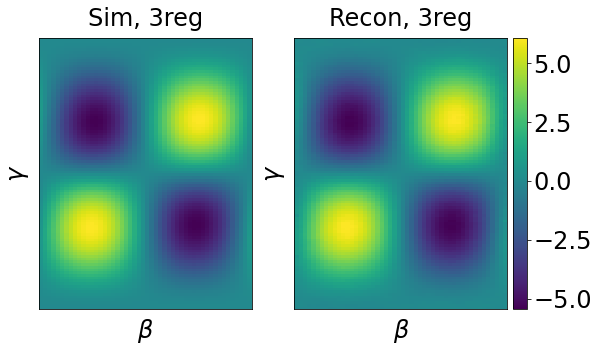

In [16]:

def vis_landscapes(
        fig,
        axs,
        landscapes, # list of np.ndarray
        labels, # list of labels of correlated landscapes
        full_range, # dict, 
        true_optima,
        title_y,
        save_path, # figure save path
        params_paths, # list of list of parameters correlated to landscapes
        recon_params_path_dict=None,
        origin_params_path_dict=None
    ):

    assert len(landscapes) == len(labels)
    assert len(landscapes) == len(params_paths)

    # print("full_range =", full_range)

    tmp = []
    
    for ls in landscapes:
        if len(ls.shape) == 4:
            shape = ls.shape
            ls = ls.reshape(shape[0] * shape[1], shape[2] * shape[3])
            print(f"reshape: {shape} -> {ls.shape}")
            p = 2
        elif len(ls.shape) == 2:
            p = 1
            pass
        else:
            raise ValueError()
        tmp.append(ls)

    landscapes = tmp

    # plt.figure
    axs = axs.reshape(-1)

    # TODO Check ij and xy
    X, Y = np.meshgrid(full_range['beta'], full_range['gamma'], indexing='ij')
    # X, Y = np.meshgrid(full_range['beta'], full_range['gamma'], indexing='xy')
    
    # c = ax.pcolormesh(X, Y, Z, cmap='viridis', vmin=Z.min(), vmax=Z.max())
    # axs[1] = axs[0].twinx()
    for idx, landscape in enumerate(landscapes):
        im = axs[idx].pcolormesh(X, Y, landscape) #, cmap='viridis', vmin=origin.min(), vmax=origin.max())
        axs[idx].set_title(labels[idx], y=title_y)
        if p == 1:
            axs[idx].set_xlabel(r'$\beta$')
            axs[idx].set_ylabel(r'$\gamma$')
        elif p == 2:
            # axs[idx].set_xlabel(r'$\beta\times\beta$')
            # axs[idx].set_ylabel('gamma x gamma')
            axs[idx].set_xlabel("12 x 12 points")
            if idx == 0:
                axs[idx].set_ylabel("15 x 15 points")

        if isinstance(true_optima, list) or isinstance(true_optima, np.ndarray):
            axs[idx].plot(true_optima[0], true_optima[1], marker="o", color='red', markersize=7, label="true optima")

        params = params_paths[idx]
        if isinstance(params, list) or isinstance(params, np.ndarray):
            xs = [] # beta
            ys = [] # gamma
            for param in params:
                xs.append(param[1])
                ys.append(param[0])

            axs[idx].plot(xs, ys, marker="o", color='purple', markersize=5, label="optimization path")
            axs[idx].plot(xs[0], ys[0], marker="o", color='white', markersize=9, label="initial point")
            axs[idx].plot(xs[-1], ys[-1], marker="s", color='white', markersize=12, label="last point")

        axs[idx].set_xticks([])
        axs[idx].set_yticks([])

    fig.colorbar(im, ax=[axs[i] for i in range(len(landscapes))], pad=0.01)
    # plt.legend()
    save_dir = os.path.dirname(save_path)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # if os.path.exists(save_path):
    #     print("same path file exists, refuse to overwrite, please check")
    #     return
    # fig.tight_layout()
    fig.savefig(save_path, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close('all')

    print("save to: ", save_path)

def vis_origin_and_recon_landscapes(
    n_qubits: int, p: int, problem: str, noise: str, seed: int, error_type: str
):
    method = 'sv'
    miti_method = ''
    sf = 0.05

    cs_seed = n_qubits
    if p == 1:
        bs = 50 # beta step
        gs = 2 * bs
    elif p == 2:
        bs = 12
        gs = 15

    data, data_fname, data_dir = load_grid_search_data(
        n_qubits=n_qubits, p=p, ansatz='qaoa', problem=problem, method=method,
        noise=noise, beta_step=bs, gamma_step=gs, seed=seed, miti_method=miti_method
    )

    plot_range = data['plot_range']

    recon_dir = f"figs/grid_search_recon/{problem}/{method}-{noise}-p={p}"

    recon_fname = f"recon-cs_seed={cs_seed}-sf={sf:.3f}-{data_fname}"
    recon_path = f"{recon_dir}/{recon_fname}"

    origin = data['data']
    recon = get_recon_landscape('qaoa', p, origin, sf, False, 
        recon_path, cs_seed)
            
    nrmse = cal_recon_error(origin.reshape(-1), recon.reshape(-1), error_type)
    print(nrmse)

    fig, axes = plt.subplots(nrows=1, ncols=2) #, figsize=(30, 22))

    vis_landscapes(
        fig,
        axes,
        landscapes=[origin, recon],
        labels=["Sim, 3reg", "Recon, 3reg"],
        full_range={
            "beta": plot_range['beta'],
            "gamma": plot_range['gamma'] 
        },
        true_optima=None,
        title_y=1.02,
        save_path=f'paper_figs/recon_n20_p1_maxcut_for_pre.png',
        params_paths=[None, None]
    )

params = {'legend.fontsize': 24,
          'figure.figsize': (10, 5),
         'axes.labelsize': 24, #'x-large',
         'axes.titlesize': 24, #'x-large',
         'xtick.labelsize': 24,
         'ytick.labelsize': 24}
plt.rcParams.update(params)

vis_origin_and_recon_landscapes(20, 1, 'maxcut', 'ideal', 3, 'NRMSE')